In [1]:
from Initialization import *

c:\libs\pycqed_py3\data
Data directory set to: c:\libs\pycqed_py3\data
c:\libs\pycqed_py3\data
Connected to: Agilent Technologies N5183B (serial:MY53271678, firmware:B.01.60) in 0.43s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/101645, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: SONY/TEK AWG520 (serial:0, firmware:SCPI:95.0 OS:1.0 USR:1.3a) in 0.15s


C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:568: FutureWarning:

ask is deprecated and will be removed in 1.10, use query instead.

c:\libs\qcodes\qcodes\instrument\parameter.py:247: UserWarning:

Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.

Snapshot: Could not update parameter: clock_source on ATS
Snapshot: Could not update parameter: sample_rate on ATS
Snapshot: Could not update parameter: clock_edge on ATS
Snapshot: Could not update parameter: decimation on ATS
Snapshot: Could not update parameter: coupling1 on ATS
Snapshot: Could not update parameter: channel_range1 on ATS
Snapshot: Could not update parameter: impedance1 on ATS
Snapshot: Could not update parameter: bwlimit1 on ATS
Snapshot: Could not update parameter: coupling2 on ATS
Snapshot: Could not update parameter: channel_range2 on ATS
Snapshot: Could not update parameter: impedance2 on ATS
Snapshot: C

controller initialized


In [2]:
station.components

{'RFLO': <N51x1: RFLO>,
 'SPEC': <RohdeSchwarz_SGS100A: SPEC>,
 'AWG': <Tektronix_AWG520: AWG>,
 'ATS': <AlazarTech_ATS9870: ATS>,
 'ATS_controller': <Demodulation_AcquisitionController: ATS_controller>,
 'HS': <HeterodyneInstrument: HS>,
 'MC': <MeasurementControl: MC>}

In [4]:
station.AWG

<Tektronix_AWG520: AWG>

In [5]:
SPEC.power()

0.0

In [8]:
RFLO.power(16)
RFLO.off()

In [ ]:
SPEC.power(-10)
SPEC.IQ_state('ON')  
SPEC.frequency(6.1565e9-0.05e9)
SPEC.off()

In [ ]:
ATS.config(clock_source='EXTERNAL_CLOCK_10_MHz_REF',
                sample_rate='1GHz_REFERENCE_CLOCK',
                clock_edge='CLOCK_EDGE_RISING',
                decimation=0,
                coupling=['DC','DC'],
                channel_range=[0.1,0.1],
                impedance=[50,50],
                bwlimit=['DISABLED','DISABLED'],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=128,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='AC',
                external_trigger_range='ETR_5V',
                trigger_delay=0,
                timeout_ticks=0
)

In [9]:
ATS.config(clock_source='INTERNAL_CLOCK',
                sample_rate=1e9,
                clock_edge='CLOCK_EDGE_RISING',
                decimation=0,
                coupling=['DC','DC'],
                channel_range=[0.1,0.1],
                impedance=[50,50],   
                bwlimit=['DISABLED','DISABLED'],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=128,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='AC',
                external_trigger_range='ETR_5V',
                trigger_delay=0,
                timeout_ticks=0
)

In [10]:
# configure the ATS controller
ATS_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=4096*1,
                 records_per_buffer=8000,#70, segmments
                 buffers_per_acquisition=5,
                 channel_selection='AB',
                 transfer_offset=0,
                 external_startcapture='ENABLED',
                 enable_record_headers='DISABLED',
                 alloc_buffers='DISABLED',
                 fifo_only_streaming='DISABLED',
                 interleave_samples='DISABLED',
                 get_processed_data='DISABLED',
                 allocated_buffers=1,  
                 buffer_timeout=5000,
)


In [ ]:
AWG.start()

In [6]:
def ATS_homodyne_acquisition(integration_start, integration_time):
    
    integration_end = integration_start + integration_time
    ATS.external_trigger_coupling._set_updated()
    ATS.external_trigger_range._set_updated()
    
    ATS_controller.pre_acquire()
    blub = ATS_controller.do_acquisition()
    ATS_controller.post_acquire()

    buffer = ATS_controller.buffer
    reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(), ATS.samples_per_record())/ATS.allocated_buffers()

#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[:50]])

    average_record_I = np.average(reshaped_buffer[0,:,:], axis = 0)-128.
    average_record_Q = np.average(reshaped_buffer[1,:,:], axis = 0)-128.
    
    offset_I = np.average(average_record_I[3000:4000])
    offset_Q = np.average(average_record_Q[3000:4000])
    
#     range_I = np.max(average_record_I[integration_start:integration_end]) \
#              -np.min(average_record_I[integration_start:integration_end])
   
#     range_Q = np.max(average_record_Q[integration_start:integration_end]) \
#              -np.min(average_record_Q[integration_start:integration_end])
    
#     integrated_output_I = np.average(average_record_I[integration_start:integration_end])#/range_I
#     integrated_output_Q = np.average(average_record_Q[integration_start:integration_end])#/range_Q
    
    
    integrated_output_I = np.average(average_record_I[integration_start:integration_end]-offset_I)#/range_I
    integrated_output_Q = np.average(average_record_Q[integration_start:integration_end]-offset_Q)#/range_Q
    
    return [integrated_output_I, integrated_output_Q, offset_I, offset_Q]

In [ ]:
ATS_homodyne_acquisition(700,1500)

In [ ]:
ATS_homodyne_acquisition(3000,100)

In [ ]:
%matplotlib inline

In [7]:
AWG.set_sequence('pulsed_spec_sequence_FILE.seq')

In [ ]:
SPEC.status()

# Readout signal Homodyned

[-1.6172641250000024,
 1.7307078499999966,
 -80.275468599999996,
 -68.959106824999992]

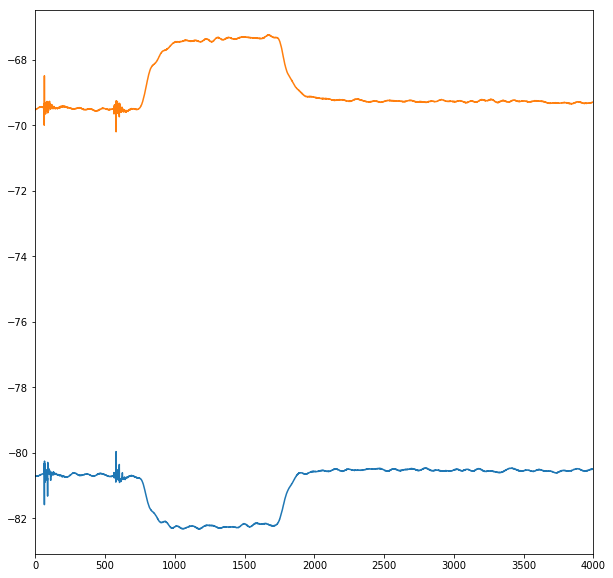

In [292]:
integration_start=750
integration_end=integration_start+1000

AWG.ch1_amp(1.0)
AWG.ch2_amp(1.0)
RFLO.frequency(5.904e9)
SPEC.frequency(5.275e9-0.05e9)
SPEC.power(-30)
RFLO.power(16)
RFLO.on()
SPEC.off()
SPEC.IQ_state.set('ON')
ATS.external_trigger_coupling._set_updated()
ATS.external_trigger_range._set_updated()

ATS_controller.pre_acquire()
blub = ATS_controller.do_acquisition()
ATS_controller.post_acquire()

buffer = ATS_controller.buffer
reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(),ATS.samples_per_record())/ATS.allocated_buffers()

# reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(), ATS.samples_per_record())/ATS.allocated_buffers()-128.

# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
# print(reshaped_buffer.flatten()[np.argsort(reshaped_b uffer.flatten())[:50]])

average_record_I = np.average(reshaped_buffer[0,:,:], axis = 0)-128.
average_record_Q = np.average(reshaped_buffer[1,:,:], axis = 0)-128.

# integrated_output_power = np.average((average_record_I[integration_start:integration_end]
#                                      +average_record_Q[integration_start:integration_end])**2)
# integrated_output_power = np.average(((average_record_I[integration_start:integration_end])**2
#                                      +(average_record_Q[integration_start:integration_end])**2))**0.5

plt.figure(figsize=(10,10))
plt.plot(average_record_I)
plt.plot(average_record_Q)
# plt.plot((average_record_Q**2+average_record_I**2)**0.5)
plt.xlim(0,4000)
ATS_homodyne_acquisition(770,1000)
# plt.ylim(-5,-1)

In [ ]:
a=reshaped_buffer
a[0][0]